In [ ]:
# Question 1
# bfloat16 200B parameter model split across 32 TPU v4p
# HBM -> VMEM
# Amount of memory in bytes = 200 * 2 / 32 = 12.5e9 bytes
# Speed of HBM BW = 1.2e12  

# Time taken = 12.5e9 / 1.2e12 =  0.01 seconds

In [ ]:
# Question 2
# v5e pod
# 16 x 16 = 256 / (4 x 2) = 32 Hosts
# 256 chips * 1 = 256 tensor cores
# Total HBM: 16 * 256 = 4096 GB
# Total FLOPs/s: 16 * 16 * 2e14 = 5.1e16

In [1]:
# Question 3
# A * x = bfloat16[B, D] * bfloat16[D, F]
# v6e peak FLOPs = 9.20e14
# HBM BW / chip = 1.6e12
# PCIe bandiwdth = 1.6e10 bytes / second
# T_math = 2 BDF / 9.2e14
# T_comm = max(PCIe_time, HBM time) = max(2(BD + DF + BF) / 1.6e10, 2(BD + DF + BF) / 1.6e12) = 2(BD + DF + BF) / 1.6e10

# T_math =T_comm = 2BDF / 9.2e14 = 2(BD + DF + BF) / 1.6e10
# 2 BDF / 2(BD + DF + BF) = 9.2e14 / 1.6e10
# 8BD^2 / (2BD + 8D^2 + 8BD) = 9.2e14 / 1.6e10
# B > 9.2e14 / 1.6e10 = 57,500 (in the book they use 1.5e10 as the PCIe bandwidth for some reason)

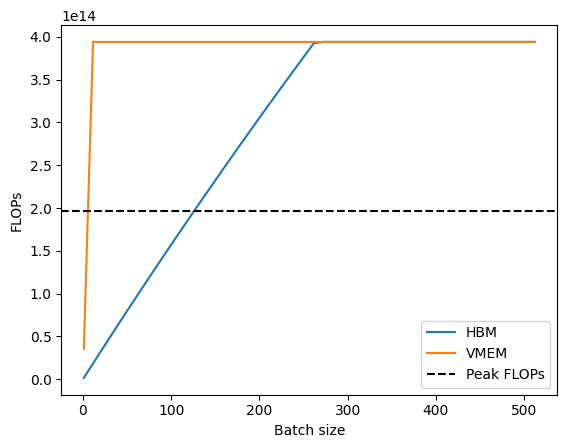

In [3]:
# Question 4
# int8[B, D] * int8[D, F] where F = 4D
# int8[B, 4096] * int8[4096, 16384]
# v5e peak FLOPs = 3.94e14
# v5e HBM BW/chip = 8.1e11

# T_math = 2BDF / 3.94e14 
# T_comm = (BD + DF + BF) / 8.1e11
# T_math = 1.34e8 / 3.94e14 * B
# T_comm = 2.5e-8 * B + 6.7e7 / 8.1e11
# Communication is bottlenecking at small batch size

# Out of VMEM
# Assume VMEM bandwidth = 22 * HBM Bandwidth
# T_comm = (BD + DF + BF) / 178.2e11
# T_comm = 1.14e-9 * B + 3.7e-6

# Critical batch size (not needed actually)
# B(2DF - 8.1e11/3.94e14 (D + F)) = 8.1e11/3.94e14 DF

import numpy as np
import matplotlib.pyplot as plt

B = np.linspace(1, 512)
PEAK_FLOPS = 1.97e14



def roofline(B, d, f, comm_flops):
    math_bytes = 2 * B * d * f
    comm_bytes = B * d + d * f + B * f
    math_time = math_bytes / 3.94e14
    comm_time = comm_bytes / comm_flops

    total_time = np.maximum(math_time, comm_time)
    flops = math_bytes / total_time
    return flops

d_large = 4096
f_large = 16384

flops_hbm = roofline(B, d_large, f_large, 8.1e11)
flops_vmem = roofline(B, d_large, f_large, 8.1e11 * 22)


plt.plot(B, flops_hbm, label='HBM')
plt.plot(B, flops_vmem, label='VMEM')
plt.axhline(PEAK_FLOPS, color='black', linestyle='--', label='Peak FLOPs')
plt.xlabel('Batch size')
plt.ylabel('FLOPs')
plt.legend()
plt.show()


In [ ]:
# Question 5
# Below logic is wrong
# v5e ICI BW/link = 4.5e10
# per-hop-latency = 1e-6
# bfloat16[8, 128, 8192]
# T_comm = 2 * 8 * 128 * 8192 / 4.5e10 = 3.7e-4
# 2-hops = 2 * per-hop-latency + 2 * T_comm

# For one bytes
# 2 * 1e-6 = 2e-6 = time that first byte arrives

# For whole transfer
# 2 * 1e-6 + 2 * 3.7e-4 = 7.4e-4

# Correct approach
# No-wrap arounds
# 2 ports to send the array to/from

# one byte:
# 6 * 1e-6 = 6e-6

# two sides so package size reduced to 8 * 128 * 8192
# Time total: 8 * 128 * 8192 / 4.5e10 = 1.86e-4 seconds
# ^ notice no need to multiply by 6 since we can assume it all occurs at the same time 

In [15]:
# Question 6

# through ICI
# A = int8[131072, 131072]
# x = bf16[8, 131072]

# # v5e ICI BW/link = 4.5e10
# per-hop-latency = 1e-6

# maximum time to go from {3, 3} to {0, 0} is the answer? 
# 6 hops (doesn't matter)
# 131072 * 131072 / (9e10)     since we assume that we are using 2 axes
# 0.19 seconds

# going from Host DRAM to chip is PCIe Bandwidth so
# 131072 * 131072 / 1.6e10 
# 1.07 seconds

# We should then just do the ICI route since it's much faster
# computation takes
# FLOPS / Peak flops
# bytes moved / hbm bandwidth

# T_math = (2 * 131072 * 131072 * 8) / 1.97e14 = 0.0014
# T_comm = (131072 * 131072 + 131072 * 8 + 8 * 131072) / 8.1e11 = 0.02 seconds
# maximum out of these two is 0.02 seconds

# total time is 0.012 + 0.02 seconds


# actual answer walkthrough
tensor_bytes = 131072 * 131072
operand_bytes = 8 * 128 * 1024
output_bytes = 8 * 128 * 1024
pcie_bandwidth = 1.5e10
ici_bandwidth = 4.5e10
hbm_bandwidth = 8.1e11
peak_flops = 1.97e14
num_tpus_per_slice = 8
num_slices = 2
cpu_to_hbm_time = tensor_bytes / pcie_bandwidth / (num_tpus_per_slice * num_slices)
tpu_to_tpu_time = tensor_bytes / (ici_bandwidth * 2)
tpu_to_hbm_time = (tensor_bytes + operand_bytes + output_bytes) / hbm_bandwidth
compute_time = 2 * tensor_bytes * operand_bytes / 131072 / peak_flops


slowest_time = max([cpu_to_hbm_time, tpu_to_tpu_time, tpu_to_hbm_time, compute_time])
print(f"Lower bound: {slowest_time}")

sequential_time = cpu_to_hbm_time + tpu_to_tpu_time + tpu_to_hbm_time + compute_time
print(f"Upper bound: {sequential_time}")

Lower bound: 0.19088743537777778
Upper bound: 0.2850778470875518
